# Introduccion

Al operador de telecomunicaciones **Interconnect** le gustaría poder pronosticar su **tasa de cancelación de clientes**. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

# Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

# Importamos librerias y Cargamos datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer

In [2]:
# Leer cada archivo CSV en un DataFrame
df_1 = pd.read_csv('/datasets/final_provider/contract.csv')
df_2 = pd.read_csv('/datasets/final_provider/personal.csv')
df_3 = pd.read_csv('/datasets/final_provider/internet.csv')
df_4 = pd.read_csv('/datasets/final_provider/phone.csv')

# Exploramos el Dataset

In [3]:
df_1.shape

(7043, 8)

In [4]:
df_2.shape

(7043, 5)

In [5]:
df_3.shape

(5517, 8)

In [6]:
df_4.shape

(6361, 2)

In [7]:
# Unir los DataFrames utilizando 'customerID' como clave
df_merged = pd.merge(df_1, df_2, on='customerID', how='left')
df_merged = pd.merge(df_merged, df_3, on='customerID', how='left')
df_merged = pd.merge(df_merged, df_4, on='customerID', how='left')

In [8]:
#una muestra del dataframe ya unido en su totalidad
df_merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [9]:
#información general del dataframe fusionado
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [10]:
#observamos si existen valores duplicados
df_merged.duplicated().sum()

0

**Conclusión inicial al analizar los datos:**

Unimos los 4 dataframes respetando el numero total de clientes siendo 7043 filas! tenemos 20 columnas , podemos ver que hay dos columnas que no se encuentran en formato datetime las pondremos en el tipo correcto,  tambien podemos ver a la columna de TotalCharges que no esta en su tipo de datos correcto, asi como podemos ver 8 columnas en las cuales hay valores nulos, trabajaremos en ellas!!

In [11]:
# Convertir las columnas 'BeginDate' y 'EndDate' a formato datetime
df_merged['BeginDate'] = pd.to_datetime(df_merged['BeginDate'])

In [12]:
df_merged['BeginDate'].dtype

dtype('<M8[ns]')

In [13]:
df_merged['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

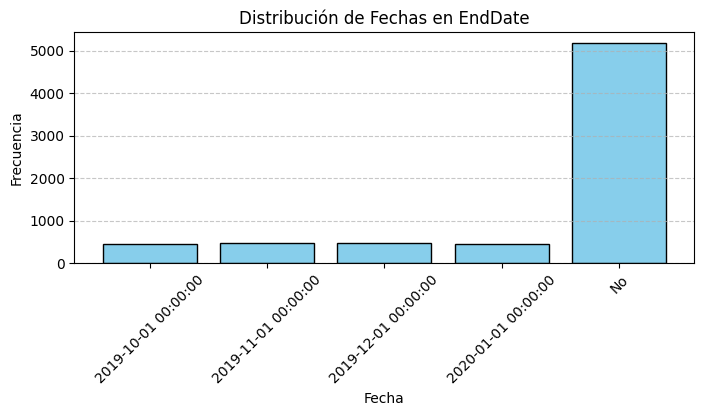

In [14]:
#Vamos a contar la frecuencia con la que aparecen cada fecha y los que aun 'no' finalizan con su servicio
date_counts = df_merged['EndDate'].value_counts().sort_index()

# Grafica de barras de los valores de la columna 'EndDate'
plt.figure(figsize=(8, 3))
plt.bar(date_counts.index, date_counts.values, color='skyblue', edgecolor='black')
plt.title('Distribución de Fechas en EndDate')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
#numero de valores de la variable 'EnDate'
date_counts

2019-10-01 00:00:00     458
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
No                     5174
Name: EndDate, dtype: int64

podemos ver que contamos con 4 periodos en los que cancelaron el servicio y es en orden del 1 de octubre del 2019 siguendo por noviembre diciembre y enero!!

In [16]:
#convertimos los valores numericos de string a float a la columna TotalCharges
df_merged['TotalCharges'] = pd.to_numeric(df_merged['TotalCharges'], errors='coerce')


In [17]:
#comprobamos que ya este hecho el cambio
df_merged['TotalCharges'].dtype

dtype('float64')

podemos ver ya los cambios realizados a nuestro analisis primario; las columnas en su formato correcto, ahora solo falta crear nuevas caracteristicas si se necesitan y trabajar con los **valores nulos!!**

# Creacion de nuevas caracteristicas

Vamos a crear una nueva columna basandonos en 'EndDate', para asi poder trabajar con nuestro modelo, sera de clasificacion binaria tomando como valor

- 0 = False
- 1 = como un True

la nueva columna se llamará 'Cancelled' haciendo referencia a la cancelación de la variable a predecir

In [18]:
# Creamos la columna 'Cancelled' basándonos en 'EndDate'
df_merged['Cancelled'] = df_merged['EndDate'].apply(lambda x: 0 if x == 'No' else 1)


# Imputacion de valores nulos

In [19]:
df_merged.isnull().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
Cancelled              0
dtype: int64

In [20]:
# Eliminar filas donde hay pocos valores nulos
df_merged = df_merged.dropna(subset=['TotalCharges'])

In [21]:
df_merged['TotalCharges'].isnull().sum()

0

eliminamos solo los valores nulos de TotalCharges al ser solo 11 filas no deberia afectar a nuestro modelo con las  trabajaremos con ellas más adelante

# Desequilibrio de clases

In [22]:
df_merged['Cancelled'].value_counts(1)

0    0.734215
1    0.265785
Name: Cancelled, dtype: float64

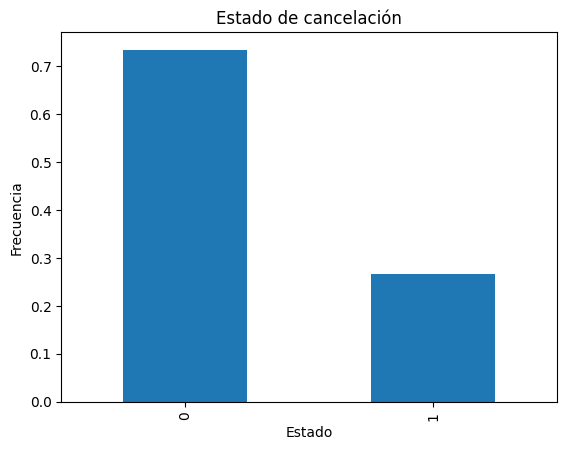

In [23]:
df_merged['Cancelled'].value_counts(1).plot(kind='bar')
plt.title('Estado de cancelación')
plt.xlabel('Estado')
plt.ylabel('Frecuencia')
plt.show()

Podemos ver como hay un desequilibrio de las clases de nuestra variable a predecir, hay más personas las cuales no han cancelado el servicio representan el %73 de los valores, trabajaremos con el desequilibrio más adelante

# Eliminación de caracteristicas

In [24]:
#vista rapida de caracteristicas que tenemos
df_merged.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Cancelled'],
      dtype='object')

In [25]:
#Vamos a eliminar variables de nuestro dataframe que no nos aportan valor a nuestro modelo
df_merged = df_merged.drop(['customerID', 'BeginDate', 'EndDate'],axis=1)

In [26]:
df_merged.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'Cancelled'],
      dtype='object')

# one hot encoding

In [27]:
#codificaremos nuestras caracteristicas categoricas a numericas para poder trabajar con nuestro modelo
df_ohe = pd.get_dummies(df_merged, drop_first= True)

In [28]:
df_ohe.shape

(7032, 21)

se crearon 21 columnas en el nuevo dataframe en 'data_ohe' 

In [29]:
del df_merged

In [30]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7032 non-null   float64
 1   TotalCharges                           7032 non-null   float64
 2   SeniorCitizen                          7032 non-null   int64  
 3   Cancelled                              7032 non-null   int64  
 4   Type_One year                          7032 non-null   uint8  
 5   Type_Two year                          7032 non-null   uint8  
 6   PaperlessBilling_Yes                   7032 non-null   uint8  
 7   PaymentMethod_Credit card (automatic)  7032 non-null   uint8  
 8   PaymentMethod_Electronic check         7032 non-null   uint8  
 9   PaymentMethod_Mailed check             7032 non-null   uint8  
 10  gender_Male                            7032 non-null   uint8  
 11  Part

# Separar caracteristicas y objetivos

In [31]:
X = df_ohe.drop('Cancelled', axis=1)
y = df_ohe['Cancelled']

In [32]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123456)

# Imputacion de valores con SimpleImputer

In [33]:
# Crear objeto SimpleImputer
imputer = SimpleImputer()

# Ajustar imputer'most_frequent'rain
imputer.fit(X_train)

SimpleImputer()

In [34]:
# Transforma X_train
X_train_transformed = imputer.transform(X_train)

# Transforma X_test
X_test_transformed = imputer.transform(X_test)

In [35]:
X_train.isna().sum()

MonthlyCharges                           0
TotalCharges                             0
SeniorCitizen                            0
Type_One year                            0
Type_Two year                            0
PaperlessBilling_Yes                     0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
gender_Male                              0
Partner_Yes                              0
Dependents_Yes                           0
InternetService_Fiber optic              0
OnlineSecurity_Yes                       0
OnlineBackup_Yes                         0
DeviceProtection_Yes                     0
TechSupport_Yes                          0
StreamingTV_Yes                          0
StreamingMovies_Yes                      0
MultipleLines_Yes                        0
dtype: int64

In [36]:
X_test.isna().sum()

MonthlyCharges                           0
TotalCharges                             0
SeniorCitizen                            0
Type_One year                            0
Type_Two year                            0
PaperlessBilling_Yes                     0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
gender_Male                              0
Partner_Yes                              0
Dependents_Yes                           0
InternetService_Fiber optic              0
OnlineSecurity_Yes                       0
OnlineBackup_Yes                         0
DeviceProtection_Yes                     0
TechSupport_Yes                          0
StreamingTV_Yes                          0
StreamingMovies_Yes                      0
MultipleLines_Yes                        0
dtype: int64

#  Escalado de datos

In [37]:
scaler = StandardScaler()
scaler.fit(X_train_transformed)
features_train = scaler.transform(X_train_transformed)
features_test = scaler.transform(X_test_transformed)

#  Modelos de aprendizaje

**mejores hiperparametros**

In [38]:
%time
from sklearn.model_selection import RandomizedSearchCV


# Modelo Random Forest con RandomSearch
rf = RandomForestClassifier(class_weight='balanced')
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}
random_search_rf = RandomizedSearchCV(rf, param_grid_rf, cv=5, n_iter=10)
random_search_rf.fit(X_train_transformed, y_train)
rf_best = random_search_rf.best_estimator_

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs


In [39]:
%time
# Modelo XGBClassifier con RandomSearch

from sklearn.preprocessing import LabelEncoder

# Codificar las etiquetas usando LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Configurar XGBClassifier con las recomendaciones
xgb_clf = XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
    
}
random_search_xgb = RandomizedSearchCV(xgb_clf, param_grid_xgb, cv=5, n_iter=10)
random_search_xgb.fit(X_train_transformed, y_train_encoded)
xgb_best = random_search_xgb.best_estimator_

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


In [ ]:
%time
# Modelo CatBoostClassifier con RandomSearch
cb_clf = CatBoostClassifier(class_weights=[1, 10])
param_grid_cb = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [0, 0.1, 0.5],
    'border_count': [32, 64, 128]
}
random_search_cb = RandomizedSearchCV(cb_clf, param_grid_cb, cv=5, n_iter=10)
random_search_cb.fit(X_train_transformed, y_train)
cb_best = random_search_cb.best_estimator_

In [ ]:
%time
# Entrenar modelos con mejores hiperparámetros
rf_best.fit(X_train_transformed, y_train)
xgb_best.fit(X_train_transformed, y_train)
cb_best.fit(X_train_transformed, y_train)

In [43]:
# Evaluar modelos
print("Random Forest:", rf_best.score(X_test_transformed, y_test))
print("XGBClassifier:", xgb_best.score(X_test_transformed, y_test))
print("CatBoostClassifier:", cb_best.score(X_test_transformed, y_test))

Random Forest: 0.7882018479033405
XGBClassifier: 0.7604832977967306
CatBoostClassifier: 0.7242359630419332


In [44]:
# Obtener predicciones

y_pred_rf = rf_best.predict(X_test_transformed)
y_pred_xgb = xgb_best.predict(X_test_transformed)
y_pred_cb = cb_best.predict(X_test_transformed)

In [45]:
# Obtener métricas
print("Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_rf))


Random Forest:
Accuracy: 0.7882018479033405
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1033
           1       0.61      0.56      0.59       374

    accuracy                           0.79      1407
   macro avg       0.73      0.72      0.72      1407
weighted avg       0.78      0.79      0.79      1407

Confusion Matrix:
 [[898 135]
 [163 211]]
AUC-ROC: 0.7167419022524086


In [46]:
# Obtener métricas
print("\nXGBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_xgb))


XGBoost:
Accuracy: 0.7604832977967306
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83      1033
           1       0.54      0.63      0.58       374

    accuracy                           0.76      1407
   macro avg       0.70      0.72      0.71      1407
weighted avg       0.77      0.76      0.77      1407

Confusion Matrix:
 [[835 198]
 [139 235]]
AUC-ROC: 0.7183337561021065


In [47]:
# Obtener métricas
print("\nCatBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred_cb))
print("Classification Report:\n", classification_report(y_test, y_pred_cb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cb))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_cb))


CatBoost:
Accuracy: 0.7242359630419332
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.75      0.80      1033
           1       0.49      0.65      0.56       374

    accuracy                           0.72      1407
   macro avg       0.67      0.70      0.68      1407
weighted avg       0.76      0.72      0.74      1407

Confusion Matrix:
 [[777 256]
 [132 242]]
AUC-ROC: 0.6996184727521212


# Gradient Boosting

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [49]:
# Crear el modelo de Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)

# Entrenar el modelo
gb.fit(X_train_transformed, y_train)

# Predecir las probabilidades para el conjunto de prueba
y_pred = gb.predict_proba(X_test_transformed)[:, 1]

# Calcular el AUC-ROC
auc = roc_auc_score(y_test, y_pred)

print("AUC-ROC:", auc)

AUC-ROC: 0.8443283412106373


In [51]:
# Predecir las etiquetas para el conjunto de prueba
y_pred = gb.predict(X_test)

# Calcular el accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calcular el classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Calcular la confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", matrix)

Accuracy: 0.8002842928216063
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.53      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.79      1407

Confusion Matrix:
 [[928 105]
 [176 198]]


# Informe

- **Accuracy:** El modelo tiene una precisión del 80.03%, lo que significa que clasifica correctamente el 80.03% de los ejemplos del conjunto de prueba.


- **Classification Report:**
La precisión para la clase 0 es del 84%, lo que significa que cuando el modelo predice la clase 0, tiene un 84% de probabilidades de estar en lo correcto.
La precisión para la clase 1 es del 65%, lo que significa que cuando el modelo predice la clase 1, tiene un 65% de probabilidades de estar en lo correcto.
El recall para la clase 0 es del 90%, lo que significa que el modelo detecta el 90% de los ejemplos de la clase 0.
El recall para la clase 1 es del 53%, lo que significa que el modelo detecta el 53% de los ejemplos de la clase 1.


- **Confusion Matrix:**
La matriz de confusión muestra que el modelo clasifica correctamente 928 ejemplos de la clase 0 y 198 ejemplos de la clase 1.
El modelo se equivoca en 105 ejemplos de la clase 0 (los clasifica como clase 1) y en 176 ejemplos de la clase 1 (los clasifica como clase 0).


- **AUC-ROC:**
El modelo tiene un AUC-ROC del 0.8443, lo que indica que el modelo es capaz de distinguir entre las clases con un buen nivel de precisión.



Podemos ver que nuestro mejor modelo fue el gradient boosting obteniendo la métrica principal pedida un **AUC-ROC: de 0.84** y la métrica adicional **Accuracy:de 0.80!!**

# Informe de solución

**El informe, responde a las siguientes preguntas:**


- ¿Qué pasos del plan se realizaron y qué pasos se omitieron (explica por qué)?

**Todos los pasos expuestos en el planteamiento de nuestro proyecto se realizarón y se profundizaron con mayor detalle como el trabajo con el desbalance de las clases hasta la creacion de una nueva caracteristica objetivo basada en nuestra union de los dataframes originales**

- ¿Qué dificultades encontraste y cómo lograste resolverlas?

**No contabamos con ciertos valores decidimos imputar los valores con 'SimpleImputer' en nuestros conjuntos de entrenamiento y prueba y solo 11 columnas fueron eliminadas de una caracteristica al ser muy pocas.**

- ¿Cuáles fueron algunos de los pasos clave para resolver la tarea?

**el analisis exploratorio de los datos,
la identificacion de nuestra variable objetivo,
el trabajo del desequilibrio de las clases,
la eliminación de ciertas caracteristicas que no nos aportaban valor a nuestro modelo,
la codificación de nuestras caracteristicas categoricas,
la creacion de los conjuntos de entrenamiento y prueba en base a nuestras caracteristicas y variable objetivo,
la imputacion de valores nulos,
el escalado de datos,
finalmente la creacion de los modelos**

- ¿Cuál es tu modelo final y qué nivel de calidad tiene?

**nuestro mejor modelo fue el gradient boosting obteniendo la métrica principal pedida un AUC-ROC: de 0.84 y la métrica adicional Accuracy:de 0.80!!**

# lista de preguntas aclaratorias

1.- Cuentan con los valores nulos de las siguientes columnas??
- 12  InternetService   5517 non-null   object        
- 13  OnlineSecurity    5517 non-null   object        
- 14  OnlineBackup      5517 non-null   object        
- 15  DeviceProtection  5517 non-null   object        
- 16  TechSupport       5517 non-null   object        
- 17  StreamingTV       5517 non-null   object        
- 18  StreamingMovies   5517 non-null   object        
- 19  MultipleLines     6361 non-null   object  

# plan aproximado para resolver la tarea

-  Realizar un analisis exploratorio de datos y realizar una limpieza de los mismos (EDA)
-  De acuerdo a lo que el cliente nos pide ver la columna objetivo para la prediccion del modelo asi como las caracteristicas y separar el conjunto de datos en entrenamiento y prueba.
-  Escoger el tipo de modelo de machine learning de acuerdo al tipo del mismo ya sea si es una tarea de clasificacion o de regresión.
-  Evaluar diferentes modelos para escoger el más adecuado
-  Obtener la metrica que el cliente nos pidio y entregar informe del mismo

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b>
El plan de proyecto muestra un buen inicio en el análisis de datos para Interconnect. Aspectos positivos incluyen:

Correcta importación y fusión de los diferentes conjuntos de datos.
Identificación adecuada de problemas en los tipos de datos y valores nulos.
Exploración inicial de las variables categóricas y sus distribuciones.
Planteamiento de preguntas aclaratorias pertinentes sobre los datos faltantes.
Esbozo general de los pasos a seguir para el análisis y modelado.

</div>
<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b>
Áreas que necesitan mejora o mayor detalle:

El plan para el análisis exploratorio de datos (EDA) podría ser más específico, indicando qué tipos de visualizaciones y análisis estadísticos se realizarán.
No se menciona cómo se manejará el desbalance de clases, que es común en problemas de predicción de cancelación de clientes.
Falta especificar qué métricas se utilizarán para evaluar los modelos, además de la métrica solicitada por el cliente.
No se menciona un plan para el manejo de variables categóricas (por ejemplo, codificación one-hot o encoding ordinal).
Sería útil incluir un paso para la selección o ingeniería de características antes del modelado.

</div>
<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b>
Puntos críticos que deben abordarse:

No se ha definido claramente la variable objetivo. Es crucial especificar cómo se determinará si un cliente ha cancelado su servicio basándose en los datos disponibles.
El plan no menciona cómo se manejarán los valores nulos en las columnas de servicios de internet y teléfono. Esta decisión puede tener un impacto significativo en el análisis y debe ser abordada explícitamente.
No se ha considerado la validación cruzada en el plan de evaluación del modelo, lo cual es esencial para evitar el sobreajuste y obtener una estimación robusta del rendimiento del modelo.

</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
Buen trabajo en este proyecto. Este proyecto está en condiciones de ser aprobado.<br>
Tu enfoque y presentación son sólidos y están bien fundamentados.<br>
<br>Es importante reconocer el esfuerzo y el análisis que has realizado. Te animo a seguir aplicando este enfoque en tus futuros proyectos. Espero que continúes desarrollando tus habilidades y conocimientos en próximos desafíos.

</div>